## Variational Signal Denoising

In [1]:
import numpy as np
import matplotlib.pyplot as plt

b)

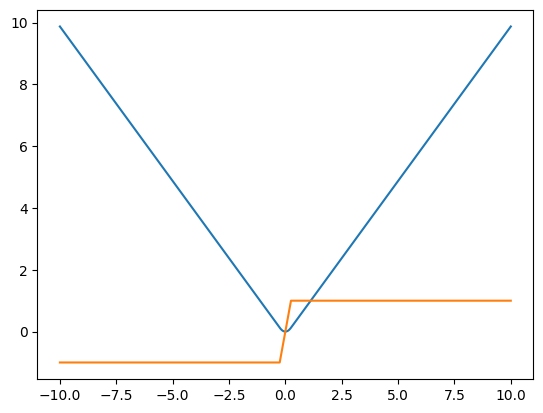

In [6]:
lambda_ = 5 * 10**(-4)
gamma = 10**3
omega = 75
u_tol = 10**(-4)
x_tol = 10**(-5)

f = np.genfromtxt('../noisy_signal.csv', delimiter=',')
f = f.reshape((-1,1))
n_x = len(f)
n_y = n_x - 1

x_start = f
I = np.eye(n_y)
zcol = np.zeros((n_y,1))
I1 = np.hstack ([I, zcol])
I2 = np.hstack([zcol, -I])
L = (I1 + I2)*999

omega_bar = np.vstack([np.zeros((n_x,1)), omega*np.ones((n_y,1))])
L_bar = np.hstack([-L, np.eye(n_y)])
A_bar = np.hstack([np.eye(n_x), np.zeros((n_x, n_y))])

def h(gamma, t):
    if abs(t) <= 1/gamma:
        return gamma * t**2 / 2
    else:
        return abs(t) - 1/(2*gamma)

def hd(gamma, t):
    if abs(t) <= 1/gamma:
        return gamma*t
    else:
        return t/abs(t)
t_range = np.linspace(-10, 10, 1000)
gamma = 4
h_r = [h(gamma, t) for t in t_range]
hd_r = [hd(gamma, t) for t in t_range]
plt.plot(t_range, h_r)
plt.plot(t_range, hd_r)
plt.show()

In [31]:
def h(gamma, t):
    abs_t = np.abs(t)
    return np.where(abs_t <= 1/gamma, gamma * t**2 / 2, abs_t - 1 / (2 * gamma))

def hd(gamma, t):
    abs_t = np.abs(t)
    return np.where(abs_t <= 1/gamma, gamma * t, np.sign(t))

def approx_1_norm(gamma, omega_bar, u):
    u_flat = u.flatten()
    h_values = h(gamma, u_flat)
    return np.dot(omega_bar.flatten(), h_values)

def approx_1_norm_grad(gamma, omega_bar, u):
    u_flat = u.flatten()
    hd_values = hd(gamma, u_flat)
    return (omega_bar.flatten() * hd_values).reshape(-1, 1)

def z_update(z, x, y, L):
    return z + L@x - y

def u_cost(A_bar, u, f, gamma, L_bar, lambda_, z):
    t_1 = 1/2 * np.linalg.norm(A_bar@u -f)**2 + lambda_/2 * np.linalg.norm(L_bar@u - z)**2
    return t_1 + approx_1_norm(gamma, omega_bar, u)

def u_cost_grad(A_bar, u, f, gamma, L_bar, lambda_, z):
    t_1 = A_bar.T @ (A_bar @ u - f) + lambda_ * L_bar.T @ (L_bar @ u - z)
    t_2 = approx_1_norm_grad(gamma, omega_bar, u)
    return t_1 + t_2

In [43]:
close = 0
iteration = 0
x_start = f #np.zeros((len(f), 1))
y_start = L@x_start
z_start = np.ones((n_y,1))
u_start = np.vstack([x_start, y_start])
alpha = 0.9
beta = 0.8

u = u_start
x = x_start
y = y_start
z = z_start

stop = 0
it = 0
while stop==0:
    it += 1
    print(f"outer iteration: {it}")
    close = 0
    
    iteration = 0
    while close==0:
        iteration += 1
        print(f"gradient iteration: {iteration}")

        backtracked=0
        t = 10
        u_grad = u_cost_grad(A_bar, u, f, gamma, L_bar, lambda_, z)
        d = - u_grad

        while backtracked==0:    
            new_u = u + t*d
            difference = u_cost(A_bar, u, f, gamma, L_bar, lambda_, z) - \
                        u_cost(A_bar, new_u, f, gamma, L_bar, lambda_, z)
            measure = - alpha * t * u_grad.T@d
            if difference < measure:
                t = beta * t
            else:
                backtracked=1
        old_u = u
        u = u + t * d
        if np.linalg.norm(u - old_u)/np.linalg.norm(u) < u_tol:
            close = 1
        if iteration >= 500:
            break
    old_x = x
    x = u[:n_x]
    y = u[-n_y:]
    z = z + L@x - y #z_update(z, x, y, L)
    if np.linalg.norm(x - old_x)/np.linalg.norm(x) < x_tol:
        stop = 1
    if it >= 10:
            break


outer iteration: 1
gradient iteration: 1
gradient iteration: 2
gradient iteration: 3
outer iteration: 2
gradient iteration: 1
outer iteration: 3
gradient iteration: 1
outer iteration: 4
gradient iteration: 1
gradient iteration: 2
outer iteration: 5
gradient iteration: 1
gradient iteration: 2
gradient iteration: 3
gradient iteration: 4
gradient iteration: 5
gradient iteration: 6
gradient iteration: 7
gradient iteration: 8
outer iteration: 6
gradient iteration: 1
outer iteration: 7
gradient iteration: 1
outer iteration: 8
gradient iteration: 1
gradient iteration: 2
gradient iteration: 3
gradient iteration: 4
gradient iteration: 5
gradient iteration: 6
gradient iteration: 7
gradient iteration: 8
gradient iteration: 9
gradient iteration: 10
gradient iteration: 11
gradient iteration: 12
gradient iteration: 13
gradient iteration: 14
gradient iteration: 15
gradient iteration: 16
gradient iteration: 17
gradient iteration: 18
gradient iteration: 19
outer iteration: 9
gradient iteration: 1
outer

In [212]:
# Initialize values
close = False
stop = False
#it = 0

x_start = f #np.zeros((len(f), 1))
y_start = L@x_start
z_start = np.ones((n_y,1))
u_start = np.vstack([x_start, y_start])
alpha = 0.2
beta = 0.5
u = u_start.copy()
x = x_start.copy()
y = y_start.copy()
z = z_start.copy()
e = []

while True:
    it += 1
    print(f"outer iteration: {it}")
    
    # close = False
    iteration = 0
    # Gradient descent loop
    while True:
        iteration += 1
        
        # Compute gradient and direction
        u_grad = u_cost_grad(A_bar, u, f, gamma, L_bar, lambda_, z)
        d = -u_grad  # Descent direction

        # Backtracking line search
        t = 1
        initial_u_cost = u_cost(A_bar, u, f, gamma, L_bar, lambda_, z)
        measure = -alpha * t * np.dot(u_grad.T, d)
        while True:
            new_u = u + t * d
            new_u_cost = u_cost(A_bar, new_u, f, gamma, L_bar, lambda_, z)
            if new_u_cost <= initial_u_cost - measure:
                break
            t *= beta
            measure *= beta #= -alpha * t * np.dot(u_grad.T, d)

        # Update `u` and check for convergence
        u_new = u + t * d
        if np.linalg.norm(u_new - u) / np.linalg.norm(u) < u_tol:
            u = u_new
            print(f"gradient iteration: {iteration}")
            break
        u = u_new
        if iteration >= 500:
            break

    # Update x, y, and z and check for convergence
    x_old = x
    x = u[:n_x]
    y = u[-n_y:]
    z += (L @ x - y)
    error = np.linalg.norm(x - x_old) / np.linalg.norm(x)
    e.append(error)
    if np.isclose(error, x_tol, atol=1e-8):
        break
    if it >= 10e4:
        break

outer iteration: 40232
gradient iteration: 1
outer iteration: 40233
gradient iteration: 1
outer iteration: 40234
gradient iteration: 1
outer iteration: 40235
gradient iteration: 1
outer iteration: 40236
gradient iteration: 1
outer iteration: 40237
gradient iteration: 1
outer iteration: 40238
gradient iteration: 1
outer iteration: 40239
gradient iteration: 1
outer iteration: 40240
gradient iteration: 1
outer iteration: 40241
gradient iteration: 1
outer iteration: 40242
gradient iteration: 1
outer iteration: 40243
gradient iteration: 1
outer iteration: 40244
gradient iteration: 1
outer iteration: 40245
gradient iteration: 1
outer iteration: 40246
gradient iteration: 1
outer iteration: 40247
gradient iteration: 1
outer iteration: 40248
gradient iteration: 1
outer iteration: 40249
gradient iteration: 1
outer iteration: 40250
gradient iteration: 1
outer iteration: 40251
gradient iteration: 1
outer iteration: 40252
gradient iteration: 1
outer iteration: 40253
gradient iteration: 1
outer iter

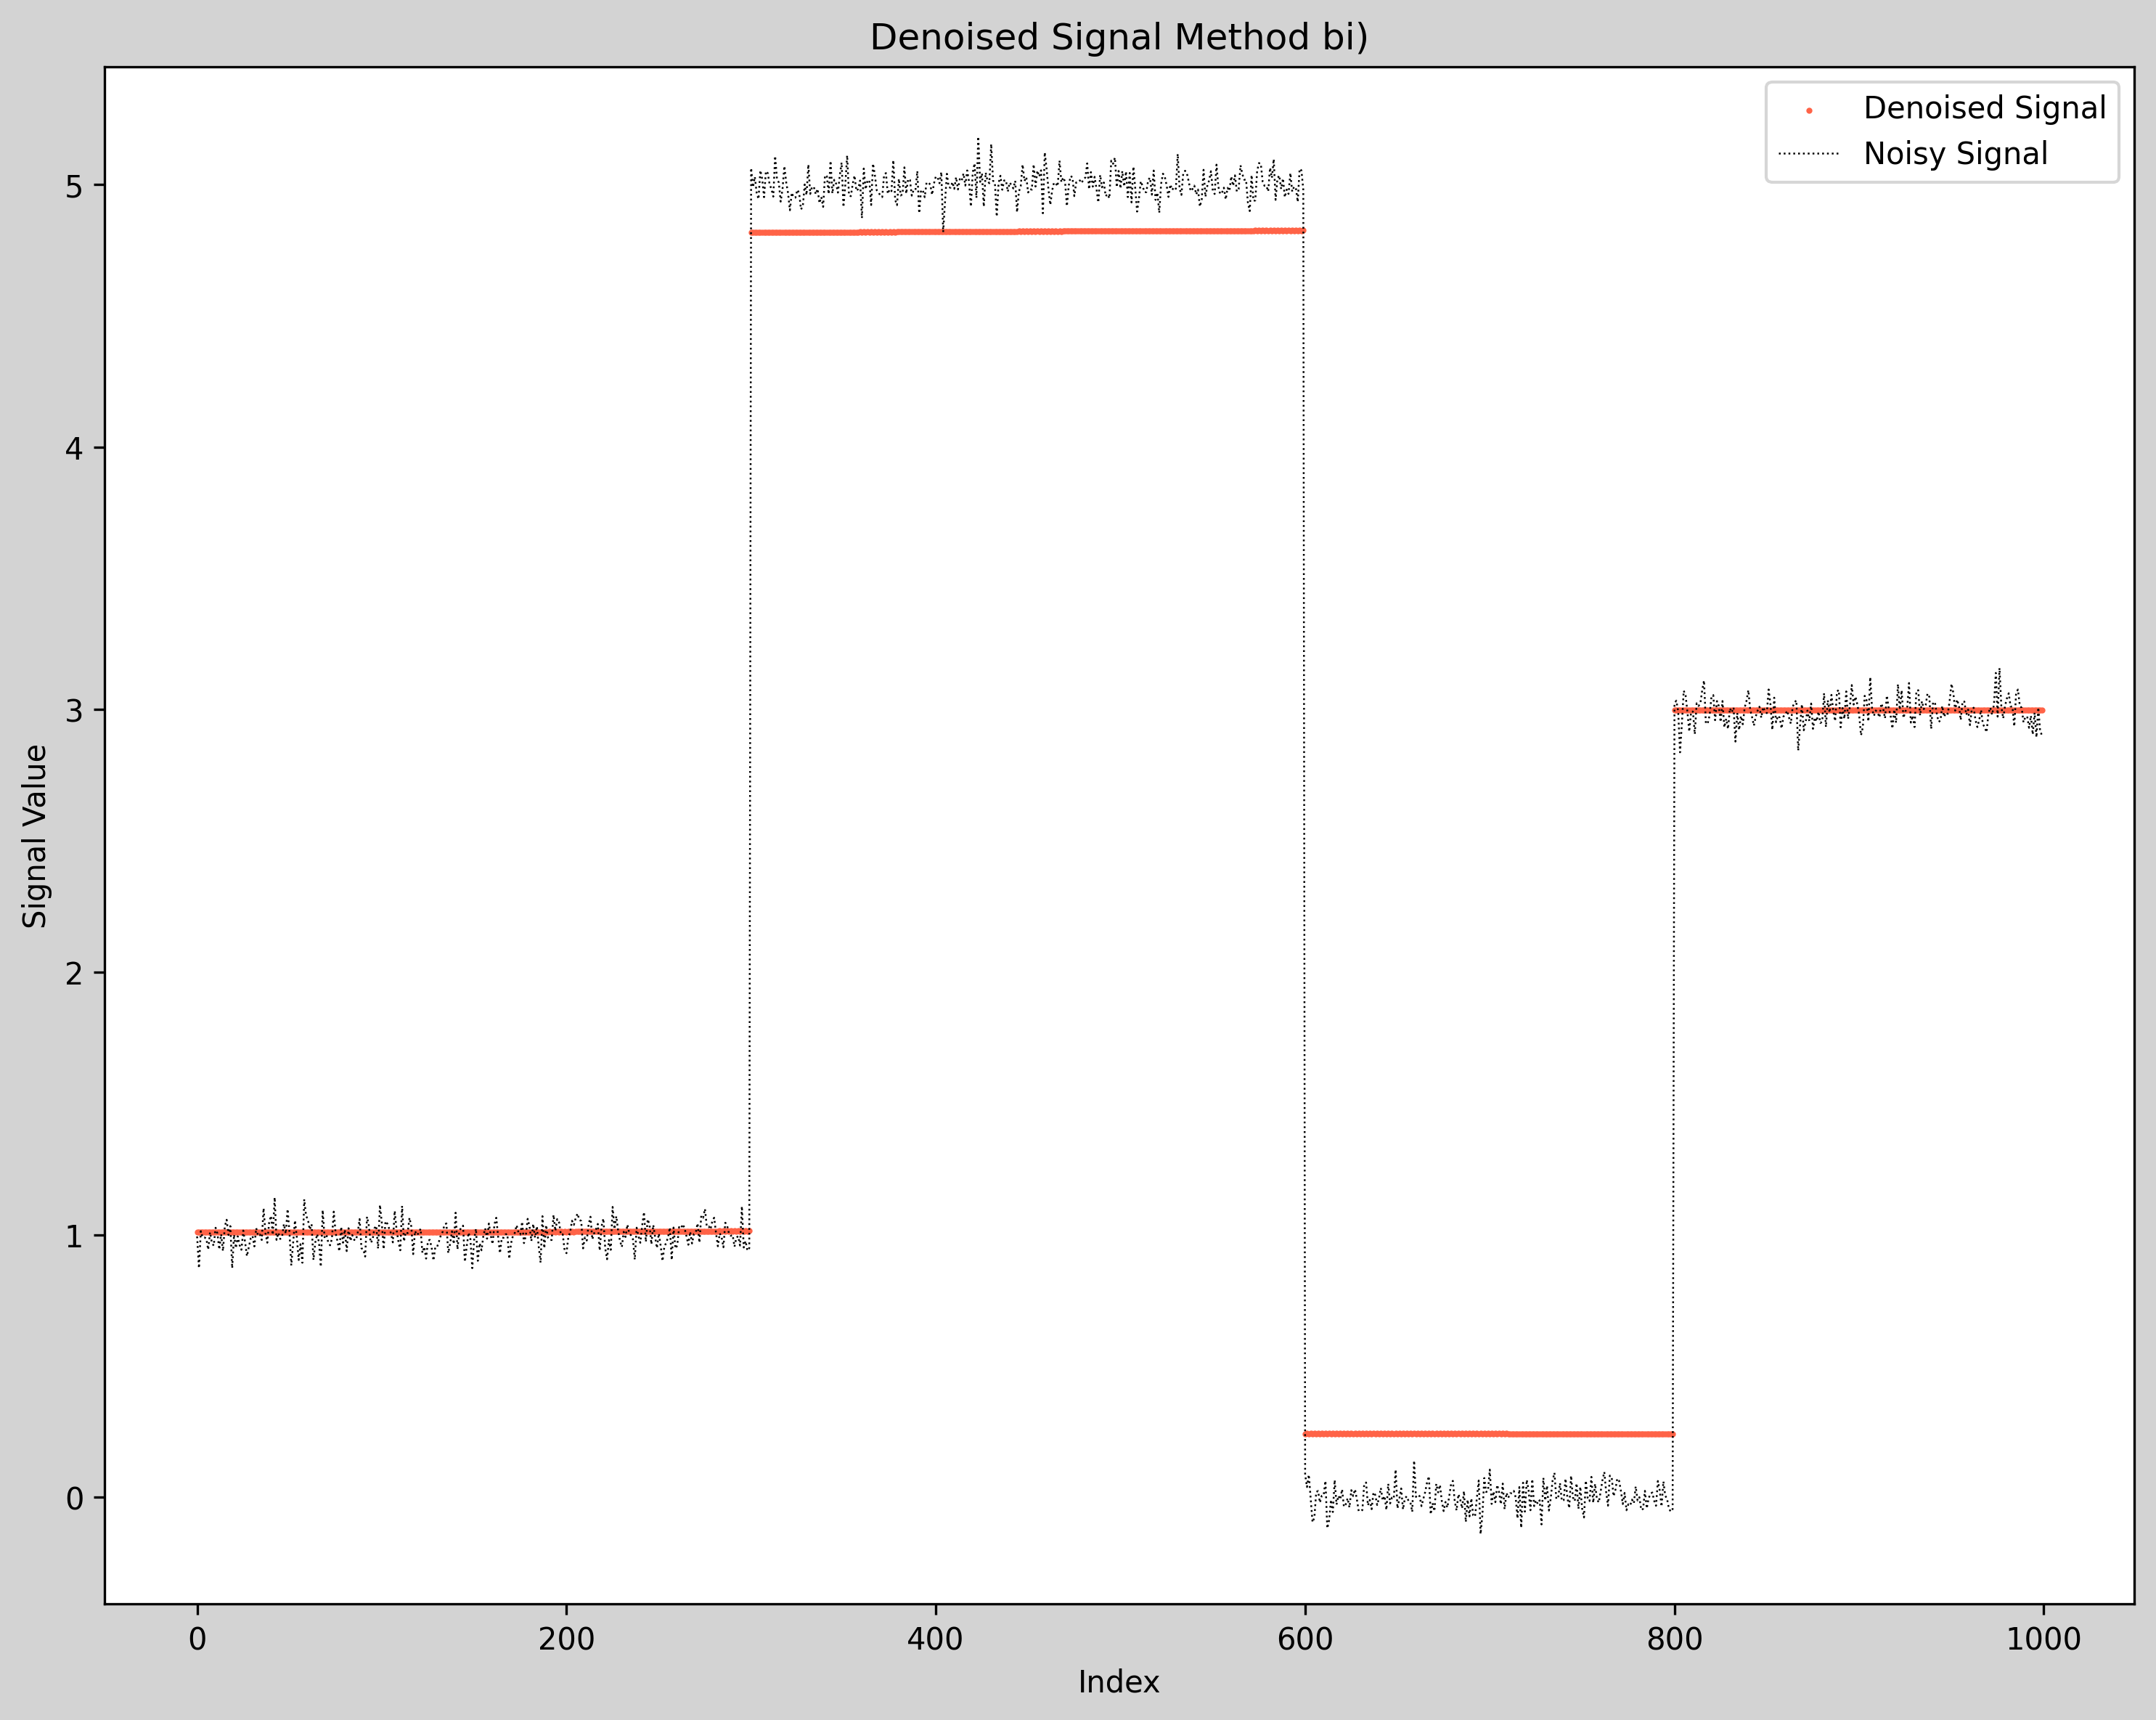

In [237]:
plt.figure(figsize=(10,8), facecolor='lightgray', dpi=300)
plt.title("Denoised Signal Method bi)")
plt.scatter(np.arange(len(x)),x, s=1, color='tomato', label = "Denoised Signal")
#plt.plot(x[:], linestyle='-', lw=0.6, color='tomato', label='opt')
plt.plot(f[:], linestyle=':', lw=0.6, color='k', label='Noisy Signal')
plt.ylabel("Signal Value")
plt.xlabel("Index")
plt.tight_layout()
plt.legend()
plt.savefig("bi_.png")
plt.show()

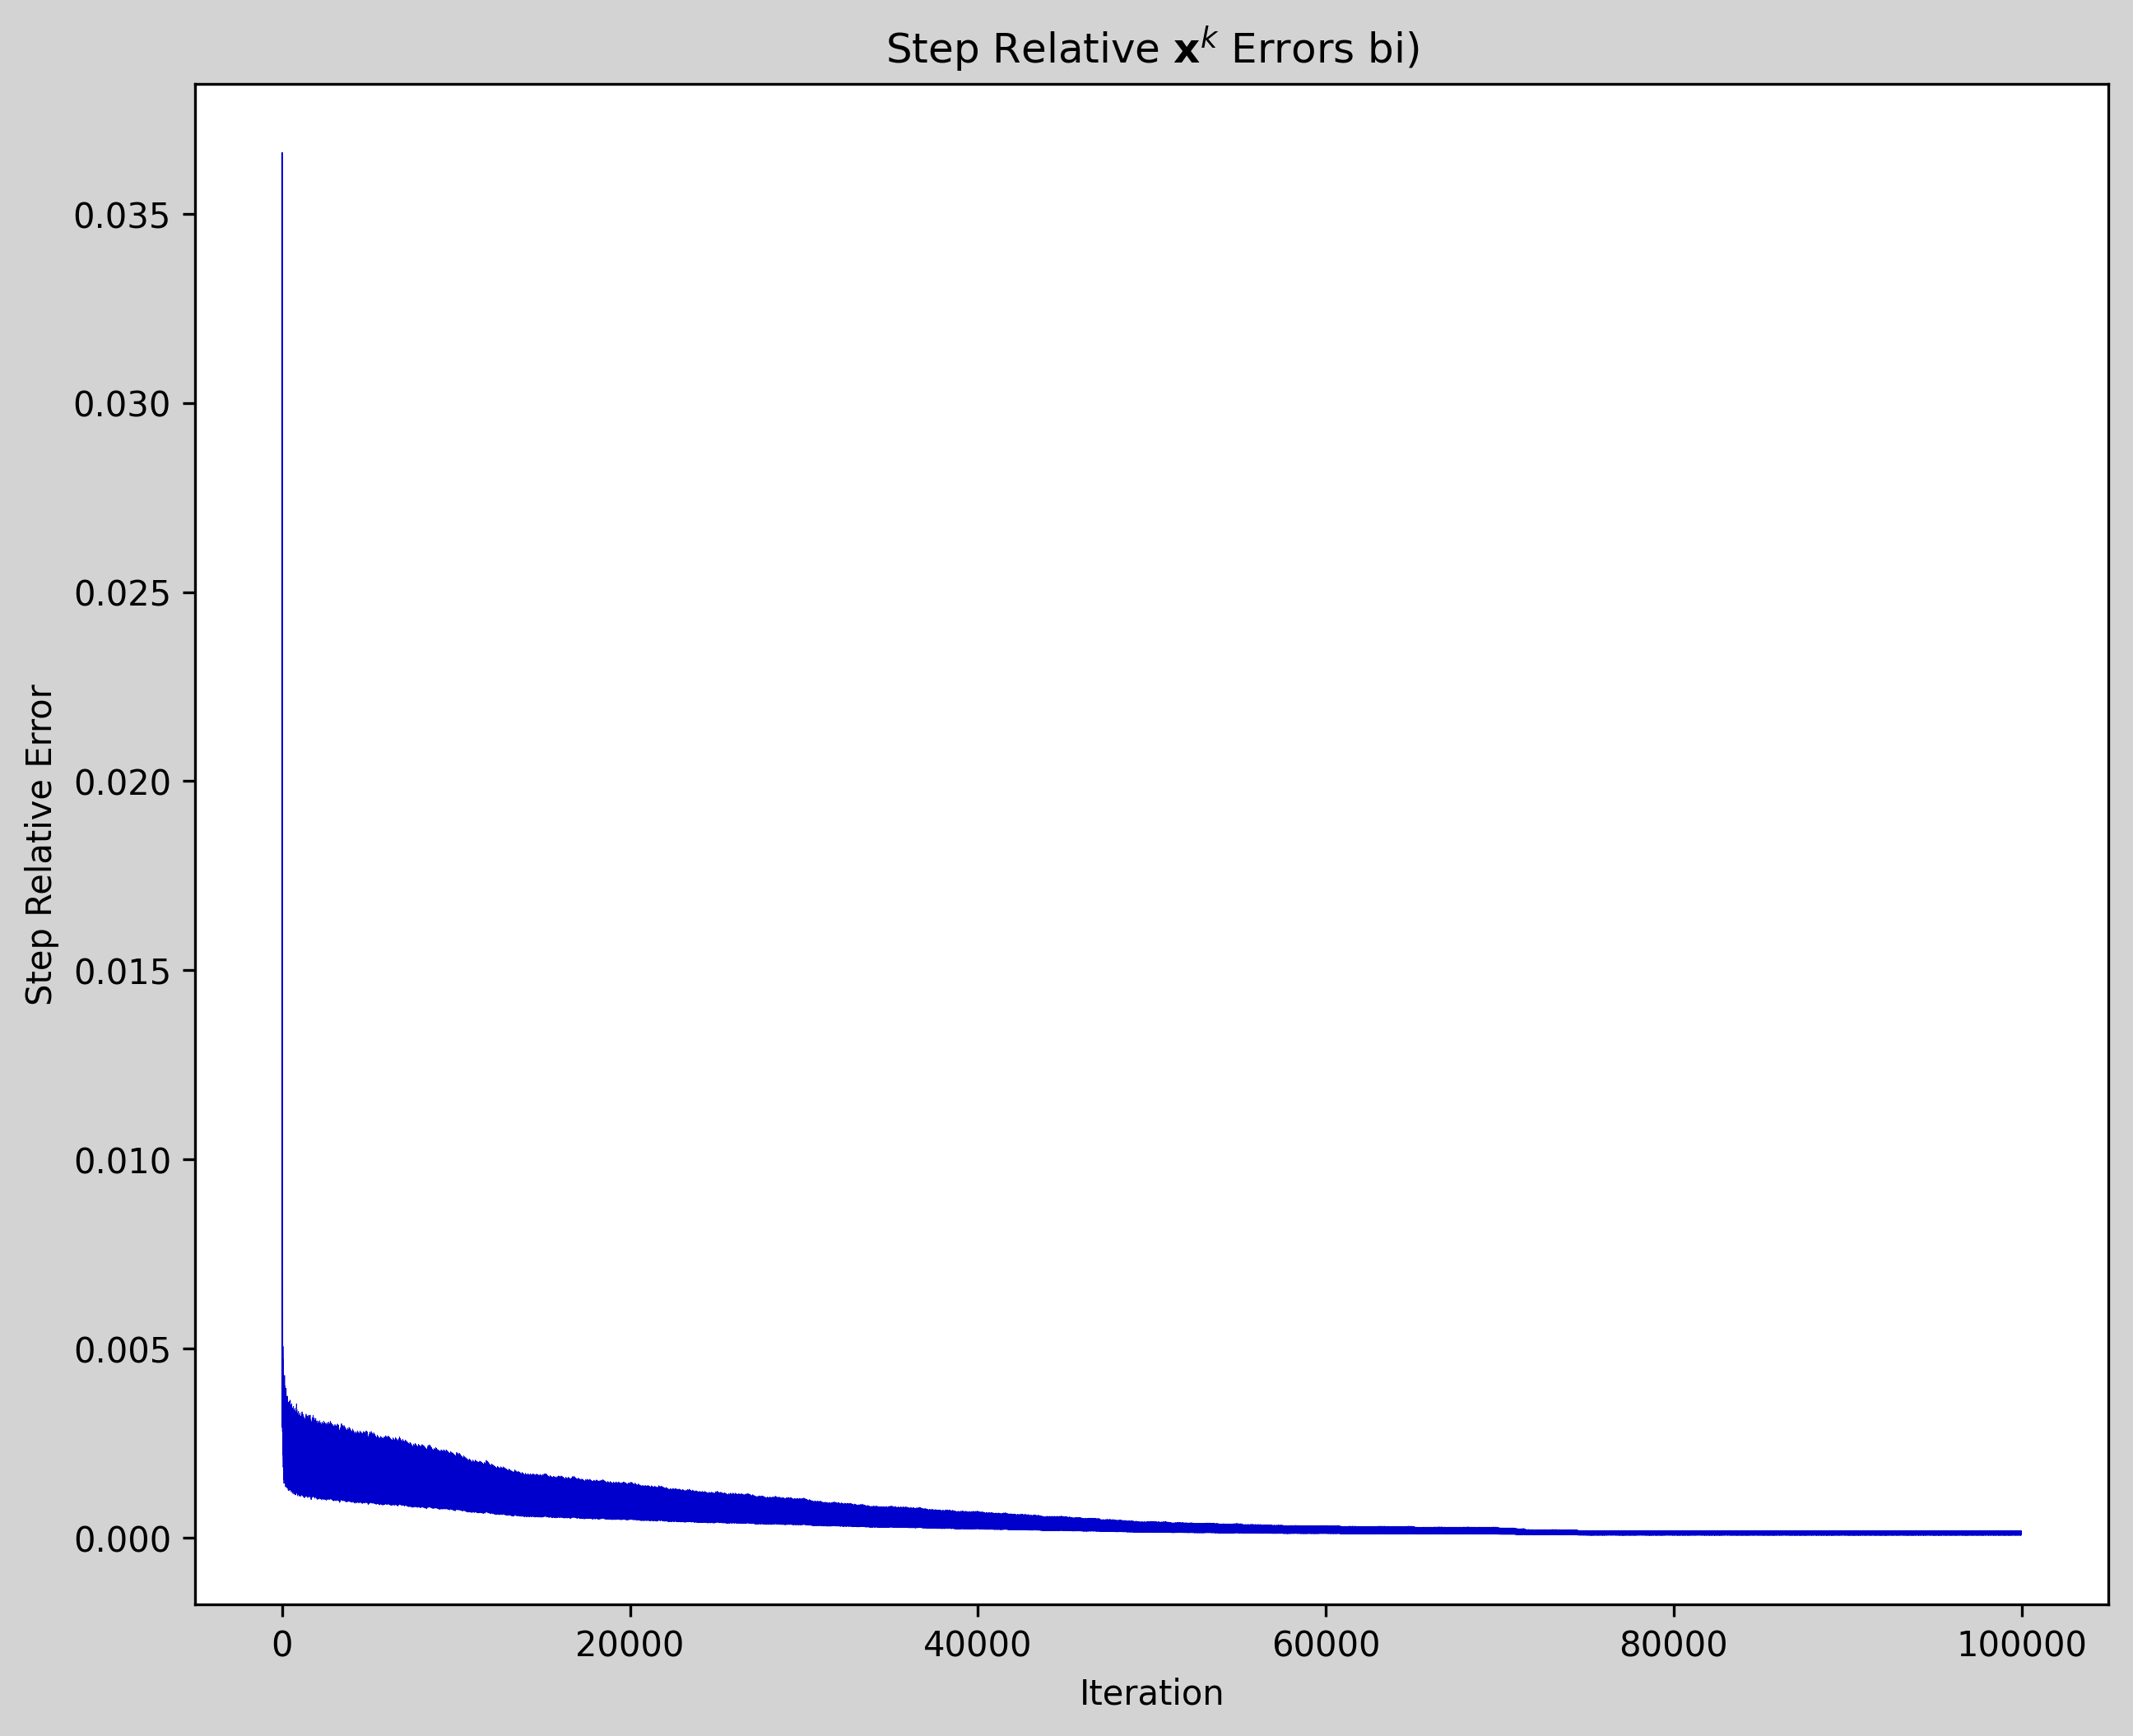

In [236]:
plt.figure(figsize=(10,8), facecolor='lightgray', dpi=300)
plt.title("Step Relative $\mathbf{x}^k$ Errors bi)")
range_ = np.arange(len(e))
plt.plot(range_[:10], e[:10], lw=0.5, linestyle='-', color='mediumblue')
plt.plot(range_[:], e[:], lw=0.2, linestyle='-', color='mediumblue')
plt.ylabel("Step Relative Error")
plt.xlabel("Iteration")
#plt.savefig("e_bi.png")
plt.show()


In [ ]:
#plt.scatter(f, x, marker='.', lw=0.1)

In [215]:
saved_x = x

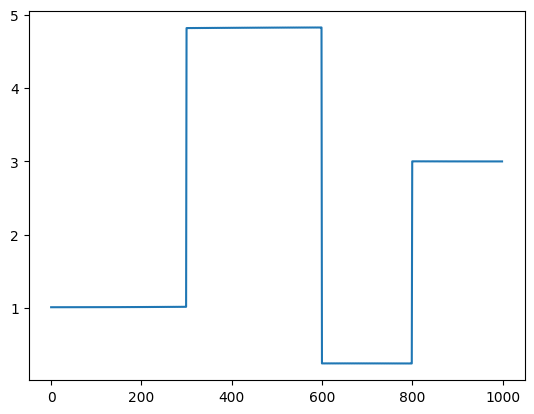

In [216]:
plt.plot(saved_x)

In [219]:
saved_x.tofile("saved_x.csv", sep=',')